In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
arr = np.memmap('image_data.npy', dtype=np.int8, mode='r', shape = (100000,275*210))
arr.shape

(100000, 57750)

In [3]:
arr = np.reshape(arr, (100000,275*210))
arr.shape

ValueError: cannot reshape array of size 5775000128 into shape (100000,57750)

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import IncrementalPCA

In [11]:
pca_dims = IncrementalPCA(n_components=500, batch_size=500)
for x in range(0,1000,500):
    pca_dims.partial_fit(arr[x:x+500])
    cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.95) + 1

/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/sklearn/decomposition/_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/home/patrick/anaconda3/envs/classification/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


reduced shape: (110, 500)
recovered shape: (110, 57750)


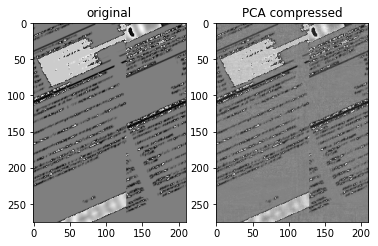

In [17]:
x = pca_dims.transform(arr[0:110])
x2 = pca_dims.inverse_transform(x)
print("reduced shape: " + str(x.shape))
print("recovered shape: " + str(x2.shape))
import matplotlib.pyplot as plt

f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(arr[100].reshape((275,210)), cmap='gray')
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(x2[100].reshape((275,210)), cmap='gray')
plt.show(block=True)

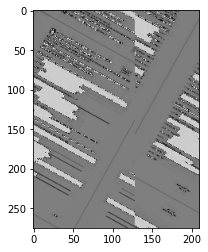

In [6]:
import matplotlib.pyplot as plt

plt.imshow(np.reshape(arr[95000],(275,210)), cmap='gray')

In [33]:
x = np.memmap('image_data_320.npy', dtype=np.int8, mode='r', shape = (100000,320))
y = np.load('target_data.npy')
print(x.shape)
print(y.shape)
x = pd.DataFrame(x)
y = pd.DataFrame(y)

(100000, 320)
(100000, 1)


In [34]:
x['target'] = y
x.shape

(100000, 321)

In [35]:
from sklearn.model_selection import train_test_split
# x = x[x.target <=1]
y = x.target
y = y == 0 * 1
y = y.astype(int)
x = x.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 320)
(40000, 320)
(60000,)
(40000,)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))
confusion_matrix(y_test, clf.predict(X_test))

0.816475


array([[32027,    45],
       [ 7296,   632]])

In [37]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['non', 'IDR'],
           yticklabels=['non', 'IDR']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [38]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(clf, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [42]:
# using the default threshold of 0.5, which is what vanilla predict does
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score
y_predict = (clf.predict_proba(X_test)[:,1] > 0.3)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.4002,   Recall: 0.2303


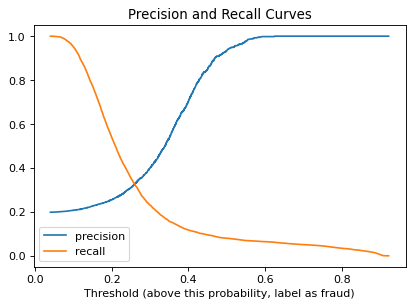

In [41]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');